In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime as dt

In [3]:
path = ('OnlineRetail.xlsx')
df = pd.read_excel(path,sheet_name="Online Retail")
df.reset_index(drop=True, inplace=True)
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [4]:
# membuat atribut baru

df['TotalQuantity'] = df["Quantity"] * df["UnitPrice"]

In [5]:
from lifetimes import BetaGeoFitter
from lifetimes.utils import summary_data_from_transaction_data

In [6]:
# menampilkan ringkasan data

data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='TotalQuantity', observation_period_end='2011-12-31')
data.head()


,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,347.0,0.000000
12347.0,6.0,365.0,389.0,599.701667
12348.0,3.0,283.0,380.0,301.480000
12349.0,0.0,0.0,40.0,0.000000
12350.0,0.0,0.0,332.0,0.000000


In [7]:
# Fit the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])


<lifetimes.BetaGeoFitter: fitted with 4372 subjects, a: 0.06, alpha: 58.51, b: 1.04, r: 0.81>

In [8]:
# Predict 3-month Customer Lifetime Value
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(3, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14911.0,145.0,372.0,395.0,910.463724,0.524394
14606.0,88.0,372.0,395.0,130.858295,0.548358
15311.0,90.0,373.0,395.0,655.266778,0.565252
17841.0,112.0,372.0,395.0,355.421429,0.624372
12748.0,114.0,373.0,395.0,254.975000,0.652989


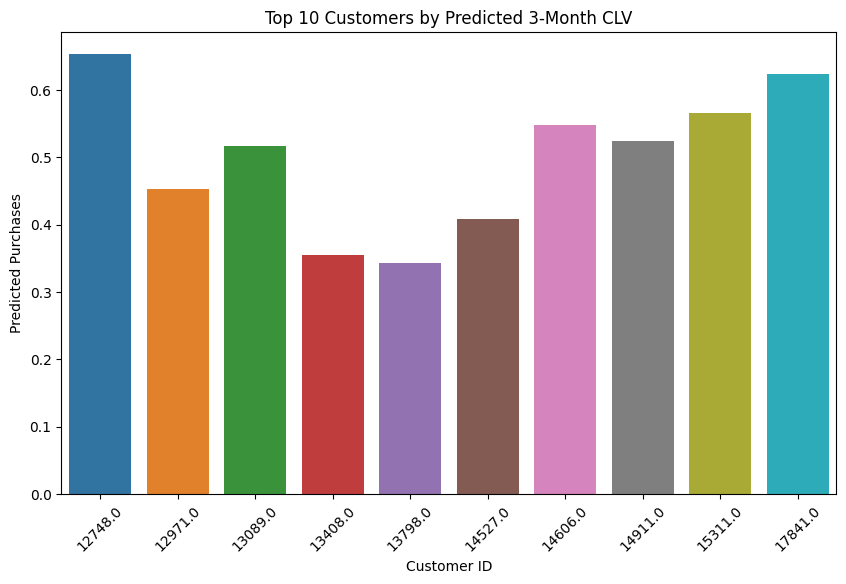

In [9]:
# Sort by predicted purchases and take the top 10
top_10_customers = data.sort_values(by='predicted_purchases', ascending=False).head(10)

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(data = top_10_customers, x = top_10_customers.index, y = 'predicted_purchases')
plt.title('Top 10 Customers by Predicted 3-Month CLV')
plt.xlabel('Customer ID')
plt.ylabel('Predicted Purchases')
plt.xticks(rotation = 45)
plt.show()

In [10]:
from sklearn.model_selection import KFold
import numpy as np

# Possible penalizer coefficient values
penalizer_coefs = [0.0, 0.01, 0.1, 1.0, 10.0]

# Best score and parameters
best_score = np.inf
best_params = None

# Number of folds
k = 5

# Create the k-fold cross-validator
kf = KFold(n_splits=k)

for penalizer_coef in penalizer_coefs:
    scores = []
    for train_index, test_index in kf.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]
        
        # Fit the BG/NBD model
        bgf = BetaGeoFitter(penalizer_coef=penalizer_coef)
        bgf.fit(train_data['frequency'], train_data['recency'], train_data['T'])

        # Predict the test data and calculate the error
        test_data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(3, test_data['frequency'], test_data['recency'], test_data['T'])
        score = ((test_data['predicted_purchases'] - test_data['frequency']) ** 2).mean()
        scores.append(score)
    
    # Calculate the average score for this penalizer_coef
    avg_score = np.mean(scores)
    print(f"penalizer_coef: {penalizer_coef}, score: {avg_score}")
    
    # If this score is better than the previous best, update the best score and parameters
    if avg_score < best_score:
        best_score = avg_score
        best_params = penalizer_coef

print(f"Best penalizer_coef: {best_params}")


penalizer_coef: 0.0, score: 55.41271621195191
penalizer_coef: 0.01, score: 55.37896466277037
penalizer_coef: 0.1, score: 55.342058126810045
penalizer_coef: 1.0, score: 55.29573493590715
penalizer_coef: 10.0, score: 55.263711648645184
Best penalizer_coef: 10.0


In [11]:
# Fit the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=10.0)
bgf.fit(data['frequency'], data['recency'], data['T'])


<lifetimes.BetaGeoFitter: fitted with 4372 subjects, a: 0.00, alpha: 8.70, b: 0.01, r: 0.14>

In [12]:
# Predict 3-month Customer Lifetime Value
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(3, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,372.0,395.0,130.858295,0.653801
15311.0,90.0,373.0,395.0,655.266778,0.668795
17841.0,112.0,372.0,395.0,355.421429,0.828571
12748.0,114.0,373.0,395.0,254.975000,0.844221
14911.0,145.0,372.0,395.0,910.463724,1.046505


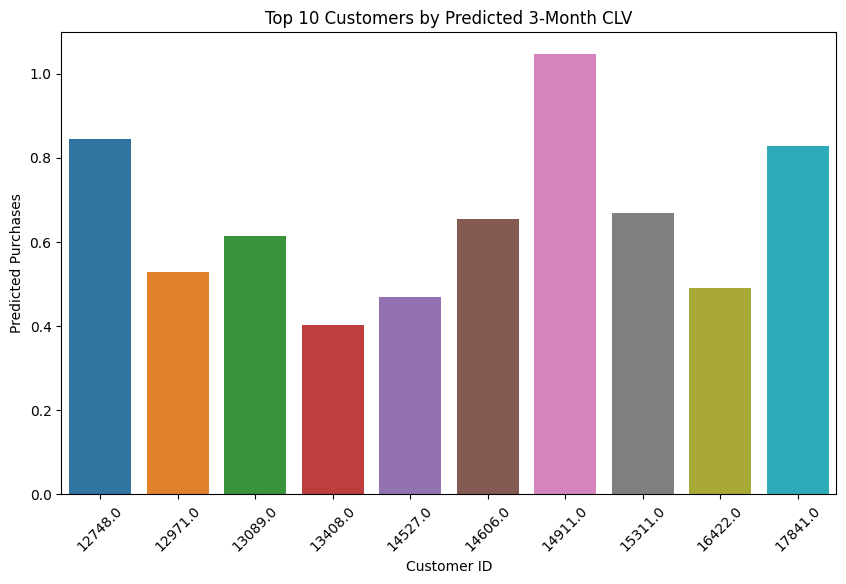

In [13]:
# Sort by predicted purchases and take the top 10
top_10_customers = data.sort_values(by='predicted_purchases', ascending=False).head(10)

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(data = top_10_customers, x = top_10_customers.index, y = 'predicted_purchases')
plt.title('Top 10 Customers by Predicted 3-Month CLV')
plt.xlabel('Customer ID')
plt.ylabel('Predicted Purchases')
plt.xticks(rotation = 45)
plt.show()

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

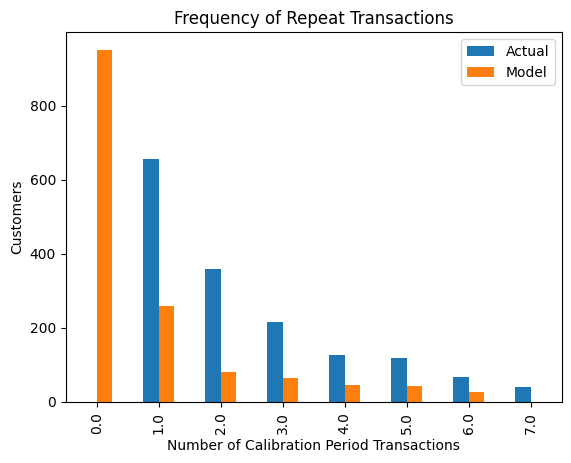

In [14]:
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data

# Create calibration and holdout data
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-30',
                                        observation_period_end='2011-12-31' )

# Filter out customers who have made only one purchase
summary_cal_holdout = summary_cal_holdout[summary_cal_holdout['frequency_cal'] > 0]

# Fit the model on the _calibration_ data
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

# Compare actual and predicted frequencies in the holdout data
plot_period_transactions(bgf, max_frequency=7)